# Rootzone model: build + rich features + walk-forward
Build master_data, engineer rich features, train RF on anchor intervals, and evaluate per-step.

In [51]:
# Repo paths (works even when notebook is in scripts/)
from pathlib import Path

def find_repo_root(start=None):
    start = Path.cwd() if start is None else Path(start)
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    return start

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
PLOTS.mkdir(exist_ok=True)


In [52]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timedelta, time
import csv
from typing import Any, Dict, List, Optional
from openpyxl import load_workbook
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(
    'ignore',
    message=r'`sklearn\.utils\.parallel\.delayed` should be used with `sklearn\.utils\.parallel\.Parallel`',
    category=UserWarning,
)



In [53]:
from pathlib import Path
from typing import Optional

def find_repo_root(start: Optional[Path] = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / 'data').exists():
            return parent
    return p

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
# OUTPUTS removed; use PROCESSED or PLOTS
print('ROOT:', ROOT)
print('RAW:', RAW)

def resolve_input(filename: str) -> Path:
    # prefer data/raw; fall back to repo root for backward compatibility
    p1 = RAW / filename
    p2 = PROCESSED / filename
    p3 = ROOT / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    if p3.exists():
        return p3
    raise FileNotFoundError(f'Cannot find {filename} in {RAW} or {ROOT}')


ROOT: C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data
RAW: C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\raw


In [54]:
# Load prebuilt master data
master_path = resolve_input("master.csv")
df = pd.read_csv(master_path, parse_dates=["timestamp"])
df = df.sort_values("timestamp").set_index("timestamp")
print("Loaded", master_path, "with", len(df), "rows")

Loaded C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master.csv with 16682 rows


In [55]:
# Build ds with anchor intervals + interval-aggregated features (t0 -> t1)
#
# Real-life intent:
# - At time t0 (current pH/EC), you also have a climate forecast over (t0, t1]
#   and a planned irrigation/fert schedule over (t0, t1].
# - So we summarize the *interval inputs* between samples and learn to predict the next sample.

anchors = df[df['ph'].notna() & df['ec_ms'].notna()].copy()
anchors['t1'] = anchors.index.to_series().shift(-1)
anchors['ph1'] = anchors['ph'].shift(-1)
anchors['ec1'] = anchors['ec_ms'].shift(-1)
anchors['gap_hours'] = (anchors['t1'] - anchors.index.to_series()).dt.total_seconds() / 3600
anchors['dph'] = anchors['ph1'] - anchors['ph']
anchors['dec'] = anchors['ec1'] - anchors['ec_ms']
anchors = anchors.dropna(subset=['t1','ph1','ec1','dph','dec'])

def build_interval_features(master: pd.DataFrame, intervals: pd.DataFrame) -> pd.DataFrame:
    rows = []
    start_time = master.index.min()
    for t0, row in intervals.iterrows():
        t1 = row['t1']
        seg = master.loc[t0:t1]
        feats: Dict[str, Any] = {}

        # Current observed rootzone state
        feats['ph0'] = float(row['ph'])
        feats['ec0'] = float(row['ec_ms'])
        feats['gap_hours'] = float(row['gap_hours'])

        # Days since start
        if 'days_after_planting' in seg.columns:
            dap = pd.to_numeric(seg['days_after_planting'], errors='coerce')
            if dap.notna().any():
                feats['days_since_start'] = float(dap.dropna().iloc[0])
            else:
                feats['days_since_start'] = (t0 - start_time).total_seconds() / 86400
        else:
            feats['days_since_start'] = (t0 - start_time).total_seconds() / 86400

        # Irrigation aggregates
        irr_sum = 0.0
        if 'irrigation_ml_current' in seg.columns:
            irr = pd.to_numeric(seg['irrigation_ml_current'], errors='coerce').fillna(0.0)
            irr_sum = float(irr.sum())
            last_irr_idx = irr[irr > 0].index.max() if (irr > 0).any() else None
            if last_irr_idx is not None:
                feats['last_event_age'] = (t1 - last_irr_idx).total_seconds() / 60
            else:
                feats['last_event_age'] = feats['gap_hours'] * 60 if feats['gap_hours'] > 0 else np.nan
        else:
            feats['last_event_age'] = feats['gap_hours'] * 60 if feats['gap_hours'] > 0 else np.nan

        feats['total_irrig_vol'] = irr_sum
        feats['irrig_to_gap_ratio'] = irr_sum / feats['gap_hours'] if feats['gap_hours'] > 0 else np.nan

        # Fert timing (last event age)
        if 'fertilization_flag' in seg.columns:
            fert = pd.to_numeric(seg['fertilization_flag'], errors='coerce').fillna(0)
            last_fert_idx = fert[fert > 0].index.max() if (fert > 0).any() else None
            if last_fert_idx is not None:
                feats['fert_last_event_age'] = (t1 - last_fert_idx).total_seconds() / 60
            else:
                feats['fert_last_event_age'] = feats['gap_hours'] * 60 if feats['gap_hours'] > 0 else np.nan
        else:
            feats['fert_last_event_age'] = feats['gap_hours'] * 60 if feats['gap_hours'] > 0 else np.nan

        # Last-2h event features (near t1)
        t2h = t1 - timedelta(hours=2)
        seg_last2h = seg.loc[t2h:t1]
        if 'irrigation_ml_current' in seg_last2h.columns:
            irr2h = pd.to_numeric(seg_last2h['irrigation_ml_current'], errors='coerce').fillna(0.0)
            feats['irr_ml_sum_last2h'] = float(irr2h.sum())
        else:
            feats['irr_ml_sum_last2h'] = 0.0
        if 'fertilization_flag' in seg_last2h.columns:
            fert2h = pd.to_numeric(seg_last2h['fertilization_flag'], errors='coerce').fillna(0)

        # Climate aggregates (only those used)
        if 'internal_air_temp_c' in seg.columns:
            s = pd.to_numeric(seg['internal_air_temp_c'], errors='coerce')
            feats['internal_air_temp_c_mean_t0_t1'] = float(s.mean())
            feats['internal_air_temp_c_max_t0_t1'] = float(s.max())
            if len(s) >= 1:
                feats['internal_air_temp_c_delta_t0_t1'] = float(s.iloc[-1] - s.iloc[0])
        if 'internal_rh_%' in seg.columns:
            s = pd.to_numeric(seg['internal_rh_%'], errors='coerce')
            feats['internal_rh_%_mean_t0_t1'] = float(s.mean())
        if 'internal_radiation' in seg.columns:
            s = pd.to_numeric(seg['internal_radiation'], errors='coerce')
            feats['internal_radiation_sum_t0_t1'] = float(s.sum())
        if 'ET0' in seg.columns:
            s = pd.to_numeric(seg['ET0'], errors='coerce')
            feats['ET0_sum_t0_t1'] = float(s.sum())

        # VPD proxy -> avg_vpd
        if 'internal_rh_%' in seg.columns and 'internal_air_temp_c' in seg.columns:
            rh = pd.to_numeric(seg['internal_rh_%'], errors='coerce')
            t = pd.to_numeric(seg['internal_air_temp_c'], errors='coerce')
            vpd_proxy = (1 - rh / 100.0) * t
            feats['vpd_proxy_mean_t0_t1'] = float(vpd_proxy.mean())

        # Optional context variables
        if 'soil_temp_pred' in seg.columns:
            st = pd.to_numeric(seg['soil_temp_pred'], errors='coerce')
            feats['soil_temp_mean_t0_t1'] = float(st.mean())
        if 'canopy_cover' in seg.columns:
            cc = pd.to_numeric(seg['canopy_cover'], errors='coerce')
            feats['canopy_mean_t0_t1'] = float(cc.mean())

        # Derived features
        feats['avg_vpd'] = feats.get('vpd_proxy_mean_t0_t1', np.nan)
        if 'internal_radiation_sum_t0_t1' in feats and feats['gap_hours'] > 0:
            feats['rad_sum_per_hour'] = feats['internal_radiation_sum_t0_t1'] / feats['gap_hours']
        else:
            feats['rad_sum_per_hour'] = np.nan
        feats['soil_temp_mean'] = feats.get('soil_temp_mean_t0_t1', np.nan)

        rows.append(feats)

    return pd.DataFrame(rows, index=intervals.index)

interval_feats = build_interval_features(df, anchors)
ds = pd.concat([anchors[['t1', 'dph', 'dec']], interval_feats], axis=1)


# Drop any rows with NaNs in features (RF cannot handle NaNs)
feature_cols_tmp = [c for c in ds.columns if c not in ['t1', 'dph', 'dec']]
ds = ds.dropna(subset=feature_cols_tmp)
print('Built ds with intervals:', len(ds), '| features:', len(feature_cols_tmp))


Built ds with intervals: 108 | features: 21


Master data rows: 16682 cols: 17
Date range: 2025-05-29 01:00:00 -> 2025-09-21 21:10:00


,missing_frac
ec_ms,0.993466
ph,0.993466
soil_temp_pred,0.000540
ET0,0.000000
internal_air_temp_c,0.000000
irrigation_ml_current,0.000000
internal_radiation,0.000000
internal_rh_%,0.000000
fertilization_flag,0.000000
canopy_cover,0.000000


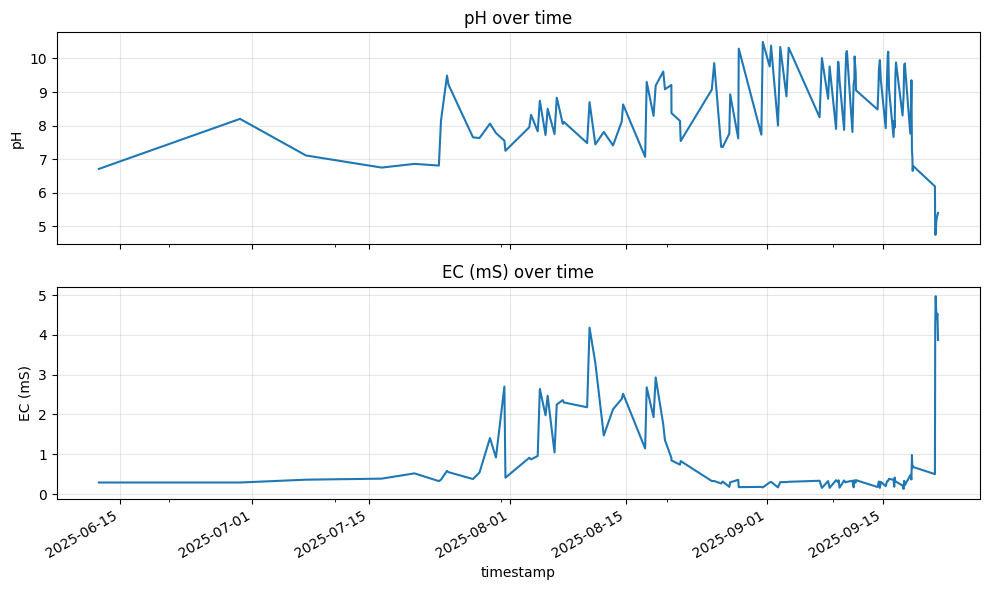

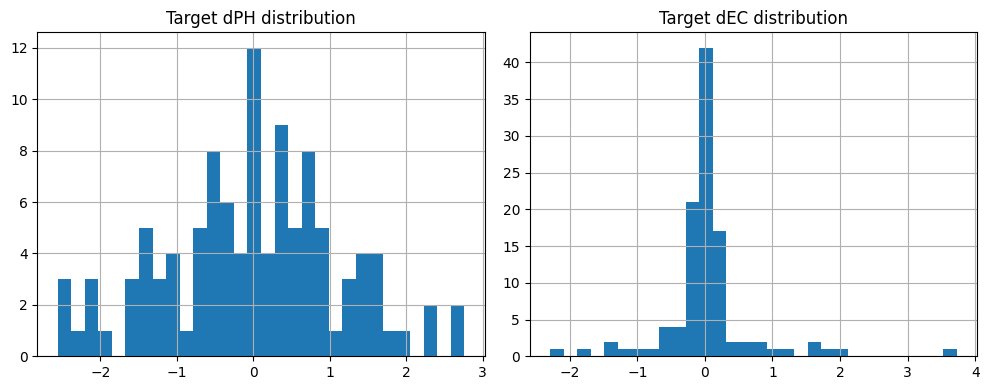

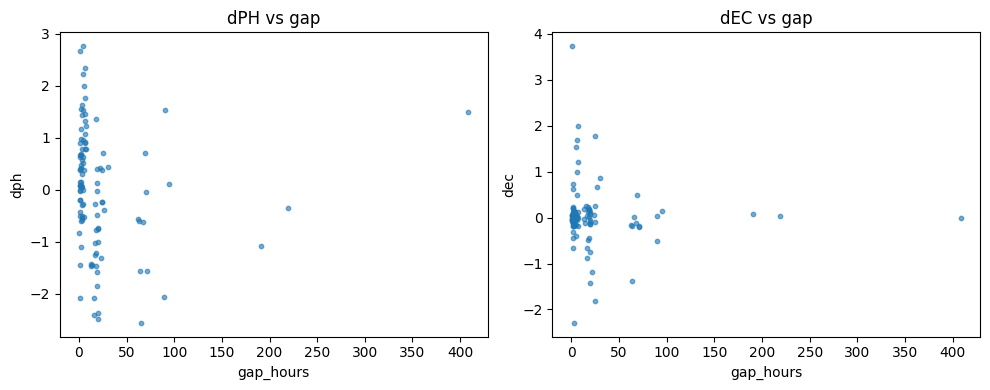

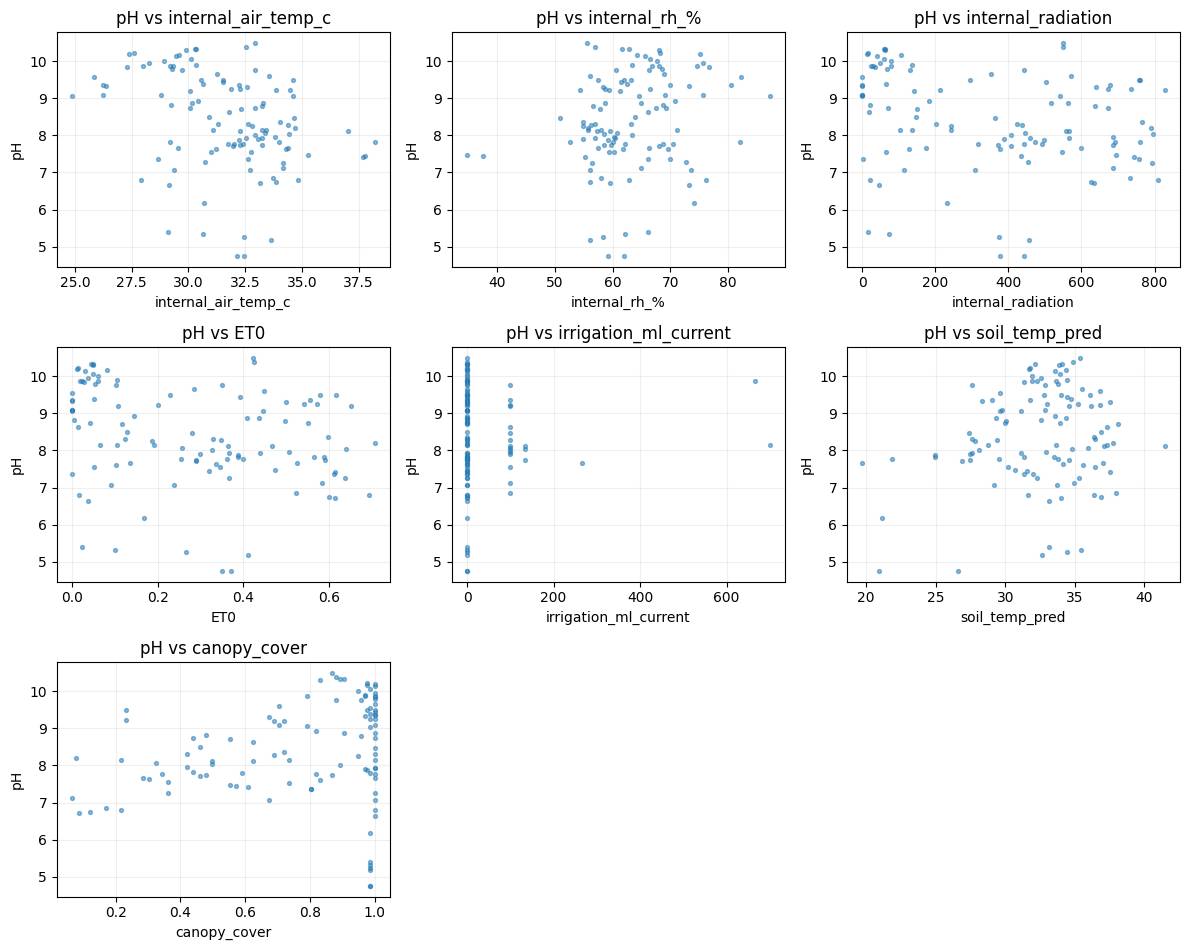

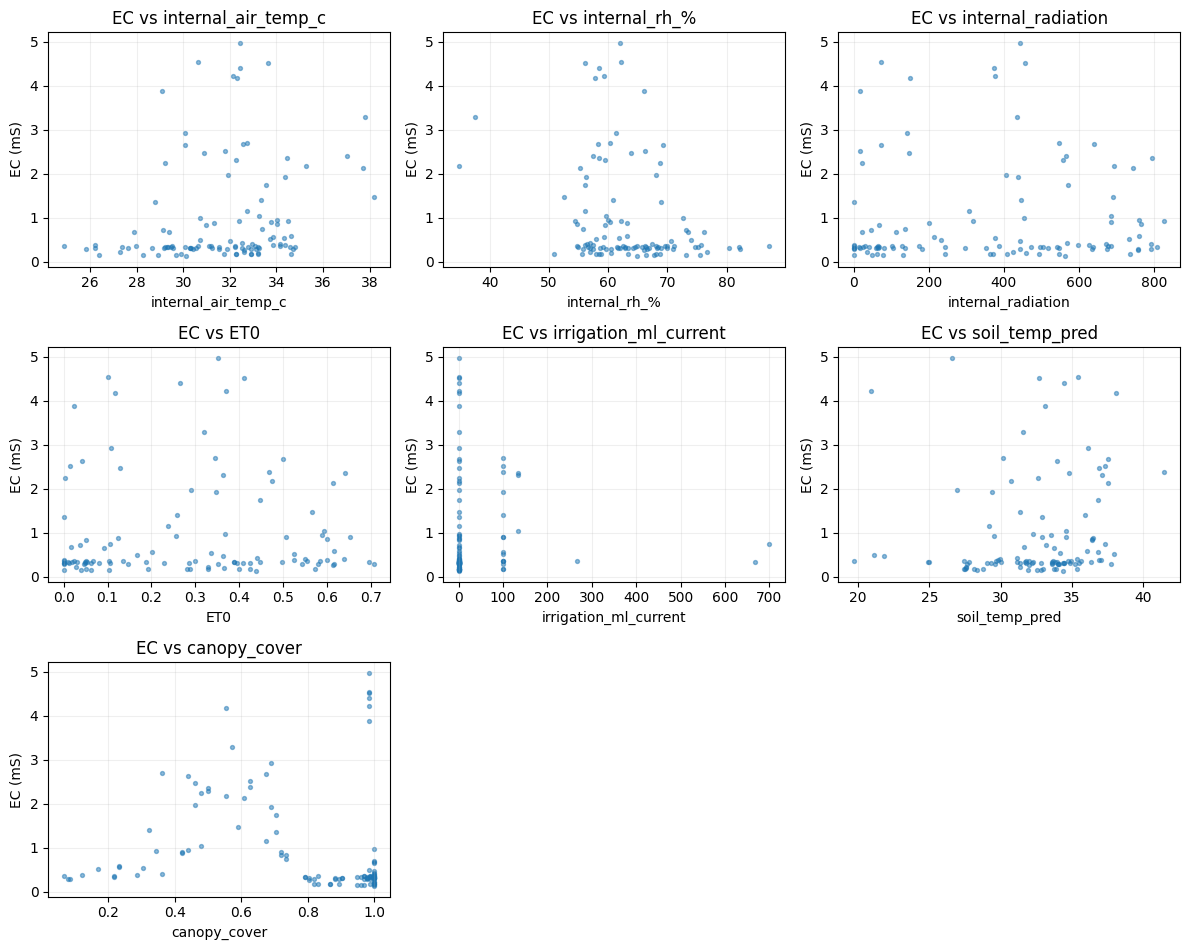

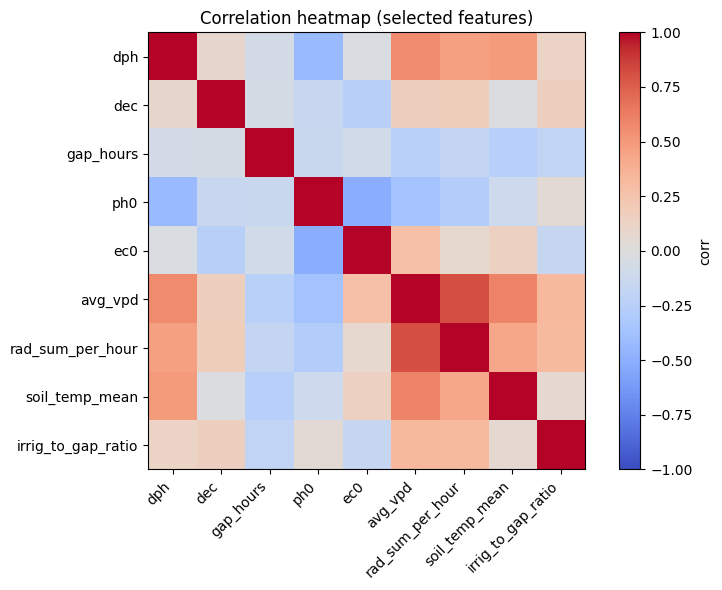

In [56]:
# Quick visuals before modeling
print('Master data rows:', len(df), 'cols:', df.shape[1])
print('Date range:', df.index.min(), '->', df.index.max())
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame('missing_frac').head(12))

# Time series for core targets (plot only non-null values)
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
if 'ph' in df.columns:
    df.loc[df['ph'].notna(), 'ph'].plot(ax=ax[0], title='pH over time')
    ax[0].set_ylabel('pH')
else:
    ax[0].set_title('pH over time (missing column)')
if 'ec_ms' in df.columns:
    df.loc[df['ec_ms'].notna(), 'ec_ms'].plot(ax=ax[1], title='EC (mS) over time')
    ax[1].set_ylabel('EC (mS)')
else:
    ax[1].set_title('EC (mS) over time (missing column)')
for a in ax: a.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Target distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'dph' in ds.columns:
    ds['dph'].hist(ax=ax[0], bins=30)
    ax[0].set_title('Target dPH distribution')
else:
    ax[0].set_title('Target dPH distribution (missing)')
if 'dec' in ds.columns:
    ds['dec'].hist(ax=ax[1], bins=30)
    ax[1].set_title('Target dEC distribution')
else:
    ax[1].set_title('Target dEC distribution (missing)')
plt.tight_layout(); plt.show()

# Gap vs targets
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'gap_hours' in ds.columns and 'dph' in ds.columns:
    ax[0].scatter(ds['gap_hours'], ds['dph'], s=10, alpha=0.6)
    ax[0].set_xlabel('gap_hours'); ax[0].set_ylabel('dph'); ax[0].set_title('dPH vs gap')
else:
    ax[0].set_title('dPH vs gap (missing)')
if 'gap_hours' in ds.columns and 'dec' in ds.columns:
    ax[1].scatter(ds['gap_hours'], ds['dec'], s=10, alpha=0.6)
    ax[1].set_xlabel('gap_hours'); ax[1].set_ylabel('dec'); ax[1].set_title('dEC vs gap')
else:
    ax[1].set_title('dEC vs gap (missing)')
plt.tight_layout(); plt.show()

# pH/EC vs selected input features (scatter)
scatter_feats = ['internal_air_temp_c', 'internal_rh_%', 'internal_radiation', 'ET0', 'irrigation_ml_current', 'soil_temp_pred', 'canopy_cover']
scatter_feats = [c for c in scatter_feats if c in df.columns]
if scatter_feats:
    n = len(scatter_feats)
    ncols = 3 if n >= 3 else n
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
    axes = np.atleast_1d(axes).ravel()
    for i, feat in enumerate(scatter_feats):
        ax = axes[i]
        if 'ph' in df.columns:
            ax.scatter(df[feat], df['ph'], s=8, alpha=0.5)
            ax.set_ylabel('pH')
        ax.set_xlabel(feat)
        ax.set_title(f'pH vs {feat}')
        ax.grid(True, alpha=0.2)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
    axes = np.atleast_1d(axes).ravel()
    for i, feat in enumerate(scatter_feats):
        ax = axes[i]
        if 'ec_ms' in df.columns:
            ax.scatter(df[feat], df['ec_ms'], s=8, alpha=0.5)
            ax.set_ylabel('EC (mS)')
        ax.set_xlabel(feat)
        ax.set_title(f'EC vs {feat}')
        ax.grid(True, alpha=0.2)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()

# Correlations for a small, interpretable subset
corr_cols = ['dph','dec','gap_hours','ph0','ec0','avg_vpd','rad_sum_per_hour','soil_temp_mean','irrig_to_gap_ratio']
corr_cols = [c for c in corr_cols if c in ds.columns]
if len(corr_cols) >= 2:
    corr = ds[corr_cols].corr()
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation heatmap (selected features)')
    plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
    plt.yticks(range(len(corr_cols)), corr_cols)
    plt.colorbar(label='corr')
    plt.tight_layout()
    plt.show()

## Targets
This notebook predicts only pH/EC deltas (`dph`, `dec`). `soil_temp_pred` is used only as an input feature (context), not as a target.

In [ ]:
# Walk-forward on ds using RF (separate pH/EC feature sets)

def select_features(cols, df, label):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"Skipping missing {label} features: {missing}")
    return [c for c in cols if c in df.columns]

# Pruned feature sets based on current importances
feature_cols_ph = [
    'ph0',
    'ec0',
    'avg_vpd',
    'rad_sum_per_hour',
    'soil_temp_mean',
    'internal_air_temp_c_mean_t0_t1',
    'internal_rh_%_mean_t0_t1',
    'internal_air_temp_c_delta_t0_t1',
    'internal_radiation_sum_t0_t1',
    'ET0_sum_t0_t1',
    'last_event_age',
    'irrig_to_gap_ratio',
    'gap_hours',
    'days_since_start',
    'irr_ml_sum_last2h',
]

feature_cols_ec = [
    'ec0',
    'ph0',
    'soil_temp_mean',
    'rad_sum_per_hour',
    'internal_radiation_sum_t0_t1',
    'days_since_start',
    'internal_rh_%_mean_t0_t1',
    'ET0_sum_t0_t1',
    'internal_air_temp_c_delta_t0_t1',
    'internal_air_temp_c_max_t0_t1',
    'avg_vpd',
    'internal_air_temp_c_mean_t0_t1',
    'gap_hours',

    'irrig_to_gap_ratio',
    'fert_last_event_age',
    'canopy_mean_t0_t1',
]

feature_cols_ph = select_features(feature_cols_ph, ds, 'pH')
feature_cols_ec = select_features(feature_cols_ec, ds, 'EC')

X_all_ph = ds[feature_cols_ph]
X_all_ec = ds[feature_cols_ec]
y_dph = ds['dph']
y_dec = ds['dec']

rf_params_ph = dict(
    n_estimators=600,
    max_depth=8,
    min_samples_leaf=3,
    min_samples_split=2,
    max_features=0.7,
    random_state=42,
    n_jobs=-1,
)

rf_params_ec = dict(
    n_estimators=700,
    max_depth=7,
    min_samples_leaf=4,
    min_samples_split=2,
    max_features=0.7,
    random_state=42,
    n_jobs=-1,
)

print(f"Selected {len(feature_cols_ph)} pH features and {len(feature_cols_ec)} EC features.")

# Short/long gap split for training
GAP_SPLIT_HOURS = 8.0

initial_train = min(30, max(5, len(ds)//5))
if len(ds) <= initial_train + 1:
    raise RuntimeError(f"Not enough intervals: n={len(ds)} for initial_train={initial_train}")

pred_rows = []
for i in range(initial_train, len(ds)):
    X_train_ph = X_all_ph.iloc[:i]
    X_test_ph = X_all_ph.iloc[i:i+1]
    X_train_ec = X_all_ec.iloc[:i]
    X_test_ec = X_all_ec.iloc[i:i+1]

    dph_model = RandomForestRegressor(**rf_params_ph)
    dec_model = RandomForestRegressor(**rf_params_ec)
    dph_model.fit(X_train_ph, y_dph.iloc[:i])
    dec_model.fit(X_train_ec, y_dec.iloc[:i])

    gap_hours = float(ds.iloc[i]['gap_hours'])
    dph_pred = float(dph_model.predict(X_test_ph)[0])
    dec_pred = float(dec_model.predict(X_test_ec)[0])
    dph_rate_pred = dph_pred / gap_hours if gap_hours > 0 else np.nan
    dec_rate_pred = dec_pred / gap_hours if gap_hours > 0 else np.nan
    ph0 = float(ds.iloc[i]['ph0']); ec0 = float(ds.iloc[i]['ec0'])
    dph_true = float(ds.iloc[i]['dph']); dec_true = float(ds.iloc[i]['dec'])
    ph1_true = ph0 + dph_true; ec1_true = ec0 + dec_true
    ph1_pred = ph0 + dph_pred
    ec1_pred = ec0 + dec_pred

    pred_rows.append({



        't0': ds.index[i], 't1': ds.iloc[i]['t1'], 'gap_hours': gap_hours,
        'ph0': ph0, 'ec0': ec0,
        'ph1_true': ph1_true, 'ec1_true': ec1_true,
        'ph1_pred': ph1_pred, 'ec1_pred': ec1_pred,
        'dph_true': dph_true, 'dec_true': dec_true,
        'dph_pred': dph_pred, 'dec_pred': dec_pred,
        'dph_rate_pred': dph_rate_pred, 'dec_rate_pred': dec_rate_pred,
        'train_intervals': i
    })

pred_df = pd.DataFrame(pred_rows).set_index('t0').sort_index()

# Add diagnostic columns from ds so error analysis can see event/irrig/fert drivers
diag_cols = [
    'irr_ml_sum_t0_t1', 'irr_event_count_t0_t1', 'irrig_to_gap_ratio',
    'fert_event_count_t0_t1', 'fert_type_binary', 'last_event_age', 'fert_last_event_age',
]
print('Tested intervals:', len(pred_df), 'of', len(ds), '| first test idx:', initial_train)

for col in diag_cols:
    if col in ds.columns and col not in pred_df.columns:
        pred_df[col] = ds.loc[pred_df.index, col]

ph1_true = pred_df['ph1_true'].values; ph1_pred = pred_df['ph1_pred'].values
ec1_true = pred_df['ec1_true'].values; ec1_pred = pred_df['ec1_pred'].values

def rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))
print("=== Overall next-observation performance ===")
print("PH MAE:", float(mean_absolute_error(ph1_true, ph1_pred)), "RMSE:", rmse(ph1_true, ph1_pred), "R2:", float(r2_score(ph1_true, ph1_pred)))
print("EC MAE:", float(mean_absolute_error(ec1_true, ec1_pred)), "RMSE:", rmse(ec1_true, ec1_pred), "R2:", float(r2_score(ec1_true, ec1_pred)))

# Metrics by fixed gap-hours bins
gap_bins = [-np.inf, 4, np.inf]
gap_labels = ['0-4h', '4+h']
def metrics_block(y_true, y_pred):
    return {
        'mae': float(mean_absolute_error(y_true, y_pred)),
        'rmse': rmse(y_true, y_pred),
        'r2': float(r2_score(y_true, y_pred))
    }

pred_df['gap_bin'] = pd.cut(pred_df['gap_hours'], bins=gap_bins, labels=gap_labels, include_lowest=True)
bin_rows = []
for gap_bin, grp in pred_df.groupby('gap_bin'):
    if len(grp) == 0:
        continue
    phm = metrics_block(grp['ph1_true'], grp['ph1_pred'])
    ecm = metrics_block(grp['ec1_true'], grp['ec1_pred'])
    bin_rows.append({
        'gap_bin': gap_bin,
        'count': int(len(grp)),
        'ph_mae': phm['mae'], 'ph_rmse': phm['rmse'], 'ph_r2': phm['r2'],
        'ec_mae': ecm['mae'], 'ec_rmse': ecm['rmse'], 'ec_r2': ecm['r2']
    })

bin_df = pd.DataFrame(bin_rows).sort_values('gap_bin')
print("=== Metrics by gap-hours bins ===")
display(bin_df)

pred_df['ph_abs_error'] = np.abs(pred_df['ph1_pred'] - pred_df['ph1_true'])
pred_df['ec_abs_error'] = np.abs(pred_df['ec1_pred'] - pred_df['ec1_true'])
pred_df['ph_signed_error'] = pred_df['ph1_pred'] - pred_df['ph1_true']
pred_df['ec_signed_error'] = pred_df['ec1_pred'] - pred_df['ec1_true']
print('Per-interval true vs predicted (all tested intervals):')
tbl = pred_df[['t1','gap_hours','ph1_true','ph1_pred','ec1_true','ec1_pred','ph_abs_error','ec_abs_error']].copy()
tbl = tbl.reset_index().rename(columns={'t0':'t0'})
tbl = tbl.rename(columns={tbl.columns[0]:'t0'})
tbl['gap_hours'] = tbl['gap_hours'].astype(float).round(3)
tbl['ph1_true'] = tbl['ph1_true'].astype(float).round(6)
tbl['ph1_pred'] = tbl['ph1_pred'].astype(float).round(6)
tbl['ec1_true'] = tbl['ec1_true'].astype(float).round(6)
tbl['ec1_pred'] = tbl['ec1_pred'].astype(float).round(6)
tbl['ph_abs_error'] = tbl['ph_abs_error'].astype(float).round(6)
tbl['ec_abs_error'] = tbl['ec_abs_error'].astype(float).round(6)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(tbl)


Selected 15 pH features and 16 EC features.
Tested intervals: 87 of 108 | first test idx: 21
=== Overall next-observation performance ===
PH MAE: 0.5968272355202195 RMSE: 0.804557590412741 R2: 0.6571553430925656
EC MAE: 0.29519963525079657 RMSE: 0.5824274077412329 R2: 0.7833166186715456
=== Metrics by gap-hours bins ===


C:\Users\User\AppData\Local\Temp\ipykernel_18312\652487134.py:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for gap_bin, grp in pred_df.groupby('gap_bin'):


,gap_bin,count,ph_mae,ph_rmse,ph_r2,ec_mae,ec_rmse,ec_r2
0,0-4h,44,0.495636,0.741446,0.800044,0.260514,0.648180,0.795475
1,4+h,43,0.700371,0.864380,0.256314,0.330692,0.506383,0.758976


Per-interval true vs predicted (all tested intervals):


,t0,t1,gap_hours,ph1_true,ph1_pred,ec1_true,ec1_pred,ph_abs_error,ec_abs_error
0,2025-08-06 10:00:00,2025-08-06 16:30:00,6.500,8.83,8.166287,2.25000,1.446743,0.663713,0.803257
1,2025-08-06 16:30:00,2025-08-07 10:00:00,17.500,8.05,8.151873,2.36000,1.809212,0.101873,0.550788
2,2025-08-07 10:00:00,2025-08-07 13:00:00,3.000,8.11,8.456117,2.30000,2.560865,0.346117,0.260865
3,2025-08-07 13:00:00,2025-08-10 08:20:00,67.333,7.48,8.177251,2.18000,2.336764,0.697251,0.156764
4,2025-08-10 08:20:00,2025-08-10 15:20:00,7.000,8.70,8.014347,4.18000,2.588623,0.685653,1.591377
5,2025-08-10 15:20:00,2025-08-11 08:10:00,16.833,7.44,8.072564,3.29000,3.840898,0.632564,0.550898
6,2025-08-11 08:10:00,2025-08-12 08:30:00,24.333,7.81,7.501917,1.47300,3.410369,0.308083,1.937369
7,2025-08-12 08:30:00,2025-08-13 11:20:00,26.833,7.41,8.080532,2.13000,2.052249,0.670532,0.077751
8,2025-08-13 11:20:00,2025-08-14 12:30:00,25.167,8.12,7.613892,2.39000,2.668872,0.506108,0.278872
9,2025-08-14 12:30:00,2025-08-14 16:20:00,3.833,8.63,8.429266,2.52000,2.269185,0.200734,0.250815


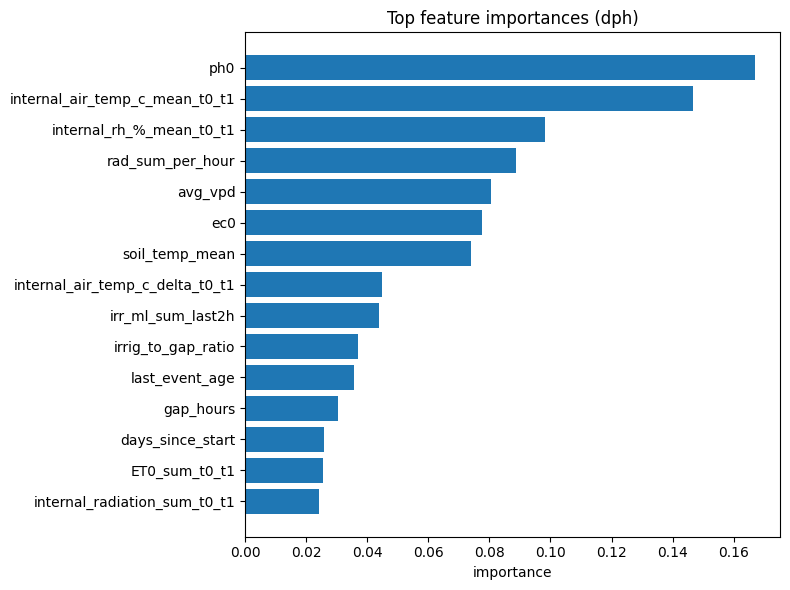

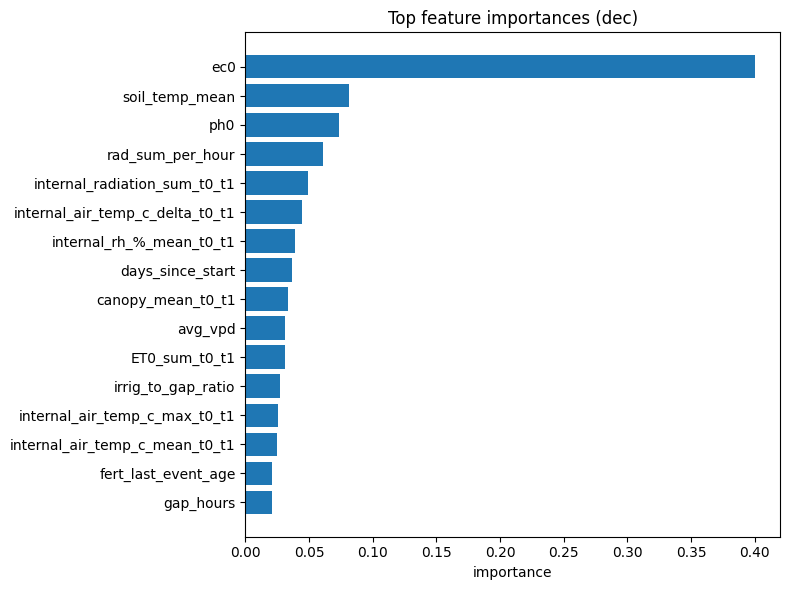

In [58]:
# Feature importance (display only) for the current feature sets
ph_rf = RandomForestRegressor(**rf_params_ph)
ec_rf = RandomForestRegressor(**rf_params_ec)
ph_rf.fit(X_all_ph, y_dph)
ec_rf.fit(X_all_ec, y_dec)

for tgt_name, est, cols in [
    ('dph', ph_rf, feature_cols_ph),
    ('dec', ec_rf, feature_cols_ec),
]:
    imp = pd.Series(est.feature_importances_, index=cols).sort_values(ascending=False)
    top = imp.head(min(25, len(imp)))
    plt.figure(figsize=(8,6))
    plt.barh(top.index[::-1], top.values[::-1])
    plt.title(f'Top feature importances ({tgt_name})')
    plt.xlabel('importance')
    plt.tight_layout()
    plt.show()



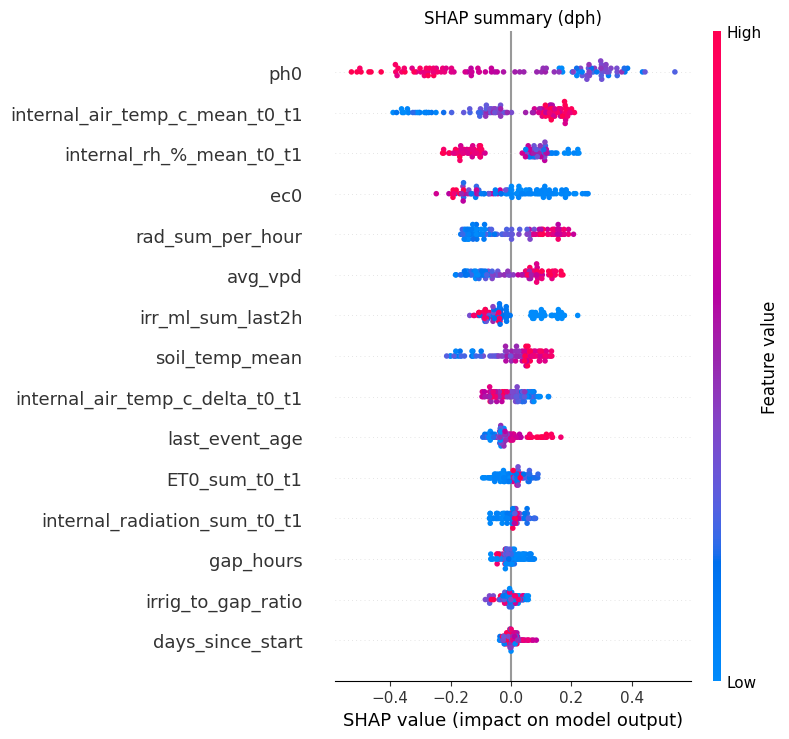

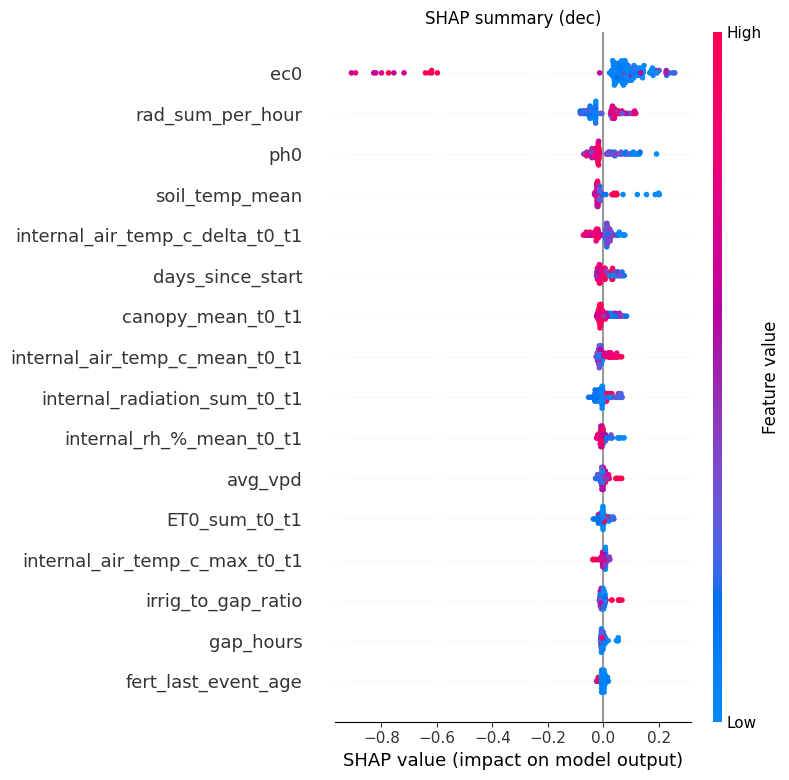

In [59]:
# SHAP summary plots (if shap is installed)
try:
    import shap
except ImportError as e:
    raise ImportError('shap is not installed in this environment. Install with: pip install shap') from e

# Train final models once (same as used in feature importances)
ph_final = RandomForestRegressor(**rf_params_ph)
ec_final = RandomForestRegressor(**rf_params_ec)
ph_final.fit(X_all_ph, y_dph)
ec_final.fit(X_all_ec, y_dec)

# Use a sample to keep runtime reasonable
X_sample_ph = X_all_ph.sample(n=min(300, len(X_all_ph)), random_state=42)
X_sample_ec = X_all_ec.sample(n=min(300, len(X_all_ec)), random_state=42)

for tgt_name, est, X_sample in [
    ('dph', ph_final, X_sample_ph),
    ('dec', ec_final, X_sample_ec),
]:
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X_sample)
    plt.figure()
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f'SHAP summary ({tgt_name})')
    plt.tight_layout()
    plt.show()


In [60]:
PROCESSED.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(PROCESSED / 'rf_rootzone_model_predictions.csv')
print('Saved', PROCESSED / 'rf_rootzone_model_predictions.csv')
pred_df[['ph_abs_error','ec_abs_error','ph_signed_error','ec_signed_error']].to_csv(PROCESSED / 'Rootzone_per_interval_errors.csv')
print('Saved', PROCESSED / 'Rootzone_per_interval_errors.csv')

Saved C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\rf_rootzone_model_predictions.csv
Saved C:\Users\User\Desktop\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\Rootzone_per_interval_errors.csv
